<a href="https://colab.research.google.com/github/Nega0619/Aiffel_Submitted_Exploration_nodes/blob/main/CV_GoindDeeper_07_Object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘은 Object Detection에 대한 학습을 진행해 보았습니다.

Object detection 용어 정리

1. Classification

주어진 물체가 무엇인지 알아내는 것

2. Localization

주어진 물체가 `어디에` 위치하는지 바운딩 박스 형식으로 나타내는 것

3. Object detection

주어진 물체가 무엇인지, 어디에 존재하는지를 알아내는 것

4. Semantic Segmentation

주어진 이미지 안의 물체의 영역을 알아내는 것, 이때의 영역을 Object Mask라고 한다.
\
폴리건으로 표현된다.

같은 종류의 물체면 같은 것으로 분류

5. Instance Segmentation

Semantic Segmentation에서 같은 종류의 물체라도 다 각각 다르게 구분.

# 1. 이미지 가져오기

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/GoingDeeper\ CV/data

/content/drive/MyDrive/GoingDeeper CV/data


In [4]:
import os
__file__ = '/content/drive/MyDrive/GoingDeeper CV/data/'
img_path = os.path.abspath(os.path.join(os.path.dirname(__file__)))+'/person.jpg'
img_path

'/content/drive/MyDrive/GoingDeeper CV/data/person.jpg'

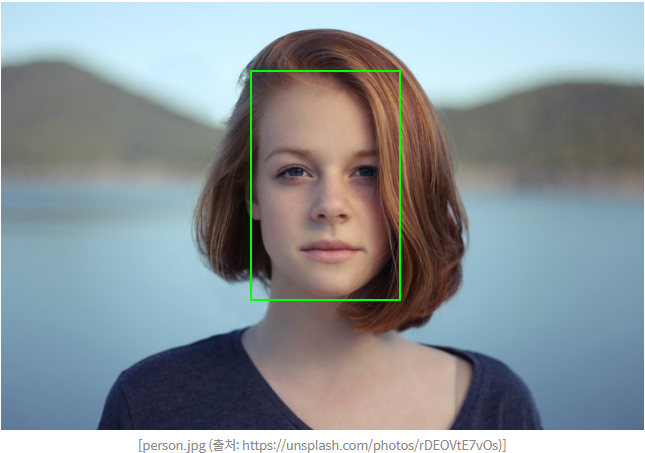

In [14]:
from PIL import Image, ImageDraw

img = Image.open(img_path)

draw = ImageDraw.Draw(img)
draw.rectangle((250, 70, 400, 300), outline=(0,255,0), width=2)

img

# 2. 바운딩 박스 결과에 대한 평가를 하는 방법 - Intersection Over Union

학습용 정답 bounding box이 있을 때 모델이 인식한 결과 bounding box를 평가하려면 어떤 지표(Metric)를 이용할 수 있을까요?

보통 평가 지표로 L1, L2 distance를 이용하지만, 이는 박스 자체의 크기에 따라 달라지는 문제가 생깁니다.

면적의 절대적인 값에 영향을 받지 않도록 두 개의 박스 차이를 상대적으로 평가하기 위한 방법 중 하나가 IoU(Intersection over Union)입니다. 교차하는 영역을 합친 영역으로 나눈 값입니다.

정답과 예측 영역이 일치하는 경우는 IoU가 1이 됩니다.


# 3. Localization

3-1. Target Label

Classification 모델을 만들 때는 Convolution layer로 구성된 백본 네트워크(backbone network)를 통해서 이미지의 특성을 추출하고 그 다음에 클래스 간 분류를 위한 fully connected layer를 추가했습니다. Classification 문제를 풀 때는 표현해야 할 클래스에 따라 최종 결과 노드의 개수가 정해졌습니다.

object detection에서는 localization을 위해 박스의 위치를 표현할 output 노드 4개를 convolution layer로 구성된 백본 네트워크 다음에 추가해야 합니다.



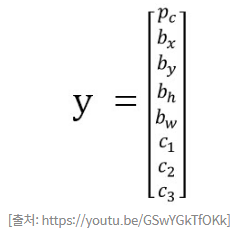

이를 위한 라벨은 위와 같습니다.

Pc는 물체가 있을 확률, c1, c2, c3은 물체가 있을때 클래스 1, 2, 3에 속할 확률입니다.

-> Pc = 0 : 배경만 존재하는 경우

bx, by, bw, bh는 바운딩 박스의 위치를 정의하기 위한 4개의 노드입니다. 이 값은 이미지 w, h로 각각 normalize된 값으로 0~1사이의 값입니다.

### Classification 모델 대신 위처럼 output을 추가해서 localization 모델을 구성한다고 했을 때, 전체적인 모델을 keras로 간단히 만들면 다음과 같습니다.

In [15]:
import tensorflow as tf
from tensorflow import keras

output_num = 1+4+3 # object_prob 1, bbox coord 4, class_prob 3

input_tensor = keras.layers.Input(shape=(224, 224, 3), name='image')
base_model = keras.applications.resnet.ResNet50(
    input_tensor=input_tensor,
    include_top=False,
    weights='imagenet',
    pooling=None,
)
x = base_model.output
preds = keras.layers.Conv2D(output_num, 1, 1)(x)
localize_model=keras.Model(inputs=base_model.input, outputs=preds)

localize_model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['image[0][0]']                  
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50


- include_top : fully_connected layer를 맨 위에 추가할 것인지 여부
- weights : `None`, `Imagenet`, `path to the weights file to be loaded`
- input_tensor : optional. model의 input으로 사용할 image
- pooling : optional. `include_top=False`일 때, 피쳐를 뽑을 때 pooling을 사용할 것인지